In [46]:
library('readr')
library('magrittr')
library('dplyr')
library('tidyr')
library('ggplot2')

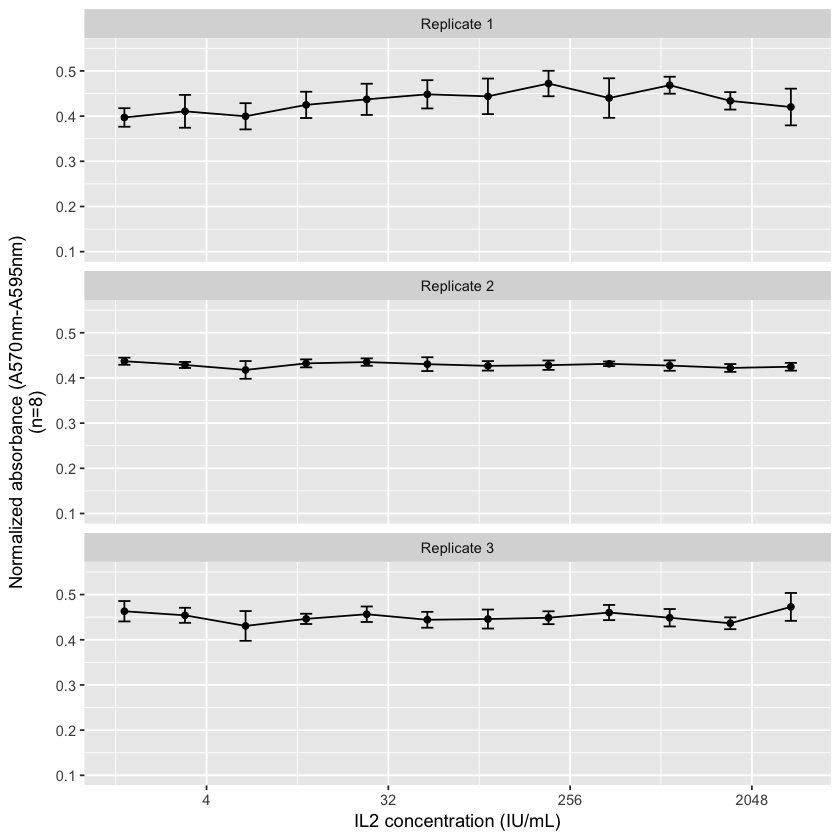

In [47]:
read_tsv(
    'il2-resazurin.tsv',
    col_types=cols(
        `Row`=col_factor(levels=LETTERS[1:8]),
        `Replicate`=col_factor(paste("R", 1:4, sep="")),
        .default=col_double()
    )
) %>%
filter(`Replicate` != "R3") %>%
mutate(`Replicate` = factor(`Replicate`, labels=c("Replicate 1", "Replicate 2", "Replicate 3"))) %>%
gather(
    key="Column",
    value="A570-A595",
    `C1`:`C12`,
    factor_key=TRUE
) %>%
group_by(`Column`, `Replicate`) %>%
summarize(
    `Abs_mean`=mean(`A570-A595`),
    `Abs_sd`=sd(`A570-A595`)
) %>%
mutate(
    `IL2_conc`=3200 / (2 ^ (as.integer(`Column`) - 1))
) %>%
ggplot(aes(x=`IL2_conc`, y=`Abs_mean`, group=`Replicate`)) +
    geom_point() +
    geom_line() +
    geom_errorbar(
        aes(ymin=`Abs_mean`-`Abs_sd`, ymax=`Abs_mean`+`Abs_sd`),
        width=.2
    ) +
    facet_wrap(~`Replicate`, ncol=1) +
    ylab('A570-A595') +
    ylim(0.1, .55) +
    scale_x_continuous(trans='log2') +
    xlab('IL2 concentration (IU/mL)') +
    ylab('Normalized absorbance (A570nm-A595nm)\n(n=8)')

In [48]:
il2_grp <- 
    read_csv(
        'il2-flow.csv',
        col_types=cols(
            `Sample`=col_character(),
            `Replicate`=col_factor(levels=paste("R", 1:4, sep="")),
            `IL2`=col_integer(),
            .default=col_double()
        )
    ) %>%
    group_by(`IL2`)

il2_flow <- 
    rbind(
        il2_grp %>%
            summarize(
                `Freq_mean`=mean(`Live cells/CD4+ CD8- | Freq. of Parent (%)`),
                `Freq_sd`=sd(`Live cells/CD4+ CD8- | Freq. of Parent (%)`),
                `CD96_mean`=mean(`Live cells/CD4+ CD8- | Mean (Comp-PE-A)`),
                `CD96_sd`=sd(`Live cells/CD4+ CD8- | Mean (Comp-PE-A)`),
            ) %>%
            mutate(`Population`="CD4+ CD8-"),
        il2_grp %>%
            summarize(
                `Freq_mean`=mean(`Live cells/CD4- CD8+ | Freq. of Parent (%)`),
                `Freq_sd`=sd(`Live cells/CD4- CD8+ | Freq. of Parent (%)`),
                `CD96_mean`=mean(`Live cells/CD4- CD8+ | Mean (Comp-PE-A)`),
                `CD96_sd`=sd(`Live cells/CD4- CD8+ | Mean (Comp-PE-A)`),
            ) %>%
            mutate(`Population`="CD4- CD8+")
    )

il2_flow

IL2,Freq_mean,Freq_sd,CD96_mean,CD96_sd,Population
0,49.350,0.6757712,1026.50,45.712872,CD4+ CD8-
32,49.025,0.4573474,1043.25,15.478480,CD4+ CD8-
64,49.175,0.4500000,1023.75,29.881711,CD4+ CD8-
128,49.475,0.6238322,1067.00,7.348469,CD4+ CD8-
256,49.550,0.5686241,1055.00,14.583095,CD4+ CD8-
512,51.000,6.4658075,1042.25,50.658168,CD4+ CD8-
0,39.175,0.6448514,791.75,37.294995,CD4- CD8+
32,39.350,0.5916080,806.50,21.794495,CD4- CD8+
64,39.100,0.6377042,784.50,29.240383,CD4- CD8+
128,39.075,0.8261356,829.75,19.276497,CD4- CD8+


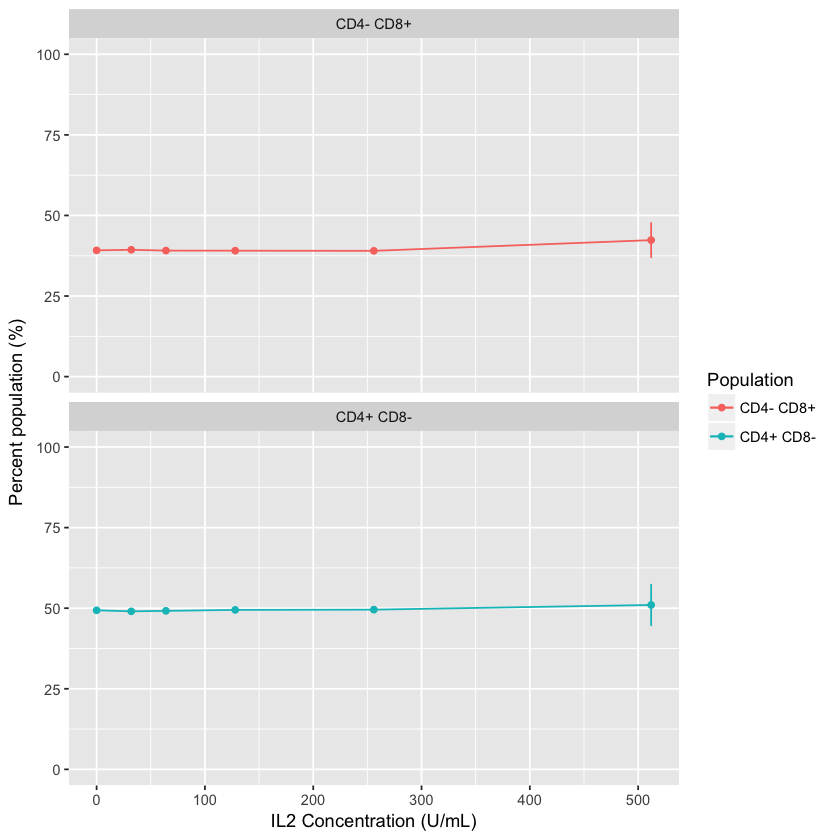

In [49]:
il2_flow %>%
    ggplot(aes(x=`IL2`, y=`Freq_mean`, color=`Population`)) +
    geom_point() +
    geom_line() +
    geom_errorbar(
        aes(ymax=`Freq_mean`+`Freq_sd`, ymin=`Freq_mean`-`Freq_sd`),
        width=.2
    ) +
    facet_wrap(~`Population`, ncol=1) +
    xlab('IL2 Concentration (U/mL)') +
    ylab('Percent population (%)') +
    ylim(0, 100)


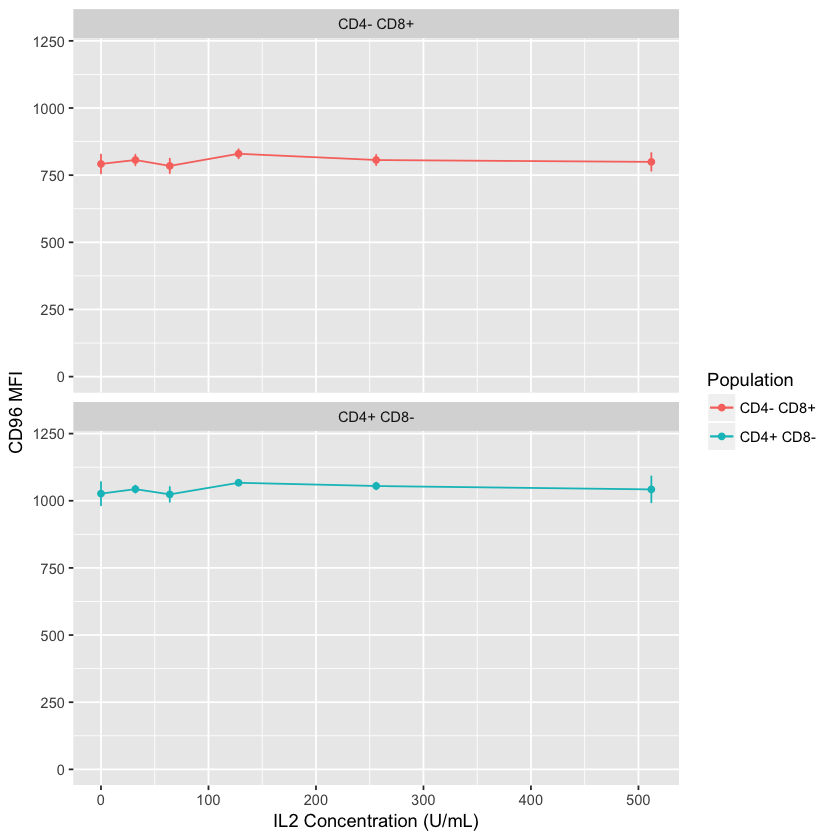

In [50]:
il2_flow %>%
    ggplot(aes(x=`IL2`, y=`CD96_mean`, color=`Population`)) +
    geom_point() +
    geom_line() +
    geom_errorbar(
        aes(ymax=`CD96_mean`+`CD96_sd`, ymin=`CD96_mean`-`CD96_sd`),
        width=.2
    ) +
    facet_wrap(~`Population`, ncol=1) +
    xlab('IL2 Concentration (U/mL)') +
    ylab('CD96 MFI') +
    ylim(0, 1200)


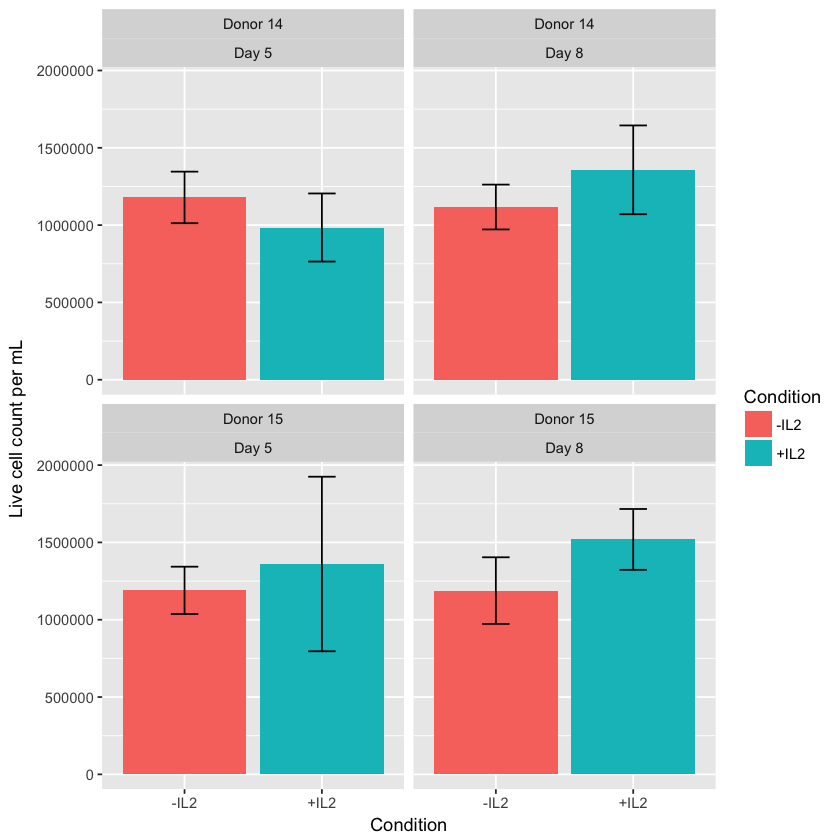

In [53]:
read_tsv(
    'il2-count-long.tsv',
    col_types=cols(
        `Donor`=col_factor(levels=c("D14", "D15")),
        `Day`=col_factor(levels=c("5", "8")),
        `Condition`=col_factor(levels=c("-IL2", "+IL2")),
        `Replicate`=col_factor(levels=paste("r", 1:3, sep="")),
        `Count No`=col_factor(levels=c("1", "2")),
        `Live count`=col_double(),
        `Live Fraction`=col_double(),
        `Dilution`=col_integer()
    )
) %>%
mutate(
    `Day`=factor(`Day`, labels=c("Day 5", "Day 8")),
    `Donor`=factor(`Donor`, labels=c("Donor 14", "Donor 15"))
) %>%
group_by(`Donor`, `Day`, `Condition`, `Replicate`) %>%
summarize(
    `Live_count_avg2`=mean(`Live count` * `Dilution`) ,
    `Fraction_avg2`=mean(`Live Fraction`)
) %>%
group_by(`Donor`, `Day`, `Condition`) %>%
summarize(
    `Live_count_avg`=mean(`Live_count_avg2`),
    `Live_count_sd`=sd(`Live_count_avg2`),
    `Live_percent_avg`=mean(`Fraction_avg2`) * 100,
    `Live_percent_sd`=sd(`Fraction_avg2`) * 100
) %>%
ggplot(aes(x=`Condition`, y=`Live_count_avg`, group=`Donor`, fill=`Condition`)) +
    geom_col() +
    geom_errorbar(
        aes(ymin=`Live_count_avg`-`Live_count_sd`, ymax=`Live_count_avg`+`Live_count_sd`),
        width=0.2
    ) +
    facet_wrap(~Donor + Day) +
    ylab('Live cell count per mL')


In [55]:
cd48_grp <-
    read_tsv(
        'il2-flow-long.tsv',
        col_types=cols(
            `Donor`=col_factor(levels=c("D14", "D15")),
            `Day`=col_factor(levels=c("5", "8")),
            `Condition`=col_factor(levels=c("-IL2", "+IL2")),
            `Replicate`=col_factor(levels=paste("r", 1:3, sep="")),
            .default=col_double()
        )
    ) %>%
    mutate(
        `Day`=factor(`Day`, labels=c("Day 5", "Day 8")),
        `Donor`=factor(`Donor`, labels=c("Donor 14", "Donor 15")),
        `Condition`=factor(`Condition`, labels=c("no IL2", "200 IU/mL"))
    ) %>%
    group_by(`Donor`, `Day`, `Condition`)

cd48_25 <- 
    rbind(
        cd48_grp %>%
            summarize(
                `Freq_mean`=mean(`Live/CD4+ CD8- | Freq. of Parent`),
                `Freq_sd`=sd(`Live/CD4+ CD8- | Freq. of Parent`),
                `CD25_mean`=mean(`Live/CD4+ CD8-/CD25+ | Freq. of Parent`),
                `CD25_sd`=sd(`Live/CD4+ CD8-/CD25+ | Freq. of Parent`),
            ) %>%
            mutate(`Population`="CD4+ CD8-"),
        cd48_grp %>%
            summarize(
                `Freq_mean`=mean(`Live/CD4- CD8+ | Freq. of Parent`),
                `Freq_sd`=sd(`Live/CD4- CD8+ | Freq. of Parent`),
                `CD25_mean`=mean(`Live/CD4- CD8+/CD25+ | Freq. of Parent`),
                `CD25_sd`=sd(`Live/CD4- CD8+/CD25+ | Freq. of Parent`),
            ) %>%
            mutate(`Population`="CD4- CD8+")
    )

cd48_25

Donor,Day,Condition,Freq_mean,Freq_sd,CD25_mean,CD25_sd,Population
Donor 14,Day 5,no IL2,77.466667,0.58594653,87.00000,0.1732051,CD4+ CD8-
Donor 14,Day 5,200 IU/mL,78.633333,1.33166562,86.70000,0.4582576,CD4+ CD8-
Donor 14,Day 8,no IL2,79.666667,0.90737717,52.90000,0.5000000,CD4+ CD8-
Donor 14,Day 8,200 IU/mL,80.633333,0.51316014,52.43333,0.8621678,CD4+ CD8-
Donor 15,Day 5,no IL2,72.966667,0.45092498,86.36667,0.4041452,CD4+ CD8-
Donor 15,Day 5,200 IU/mL,73.300000,1.05356538,85.83333,0.1527525,CD4+ CD8-
Donor 15,Day 8,no IL2,84.600000,0.20000000,44.03333,1.0066446,CD4+ CD8-
Donor 15,Day 8,200 IU/mL,85.100000,0.70000000,43.13333,1.4571662,CD4+ CD8-
Donor 14,Day 5,no IL2,11.466667,0.11547005,85.80000,0.3605551,CD4- CD8+
Donor 14,Day 5,200 IU/mL,11.366667,0.11547005,86.43333,0.3055050,CD4- CD8+


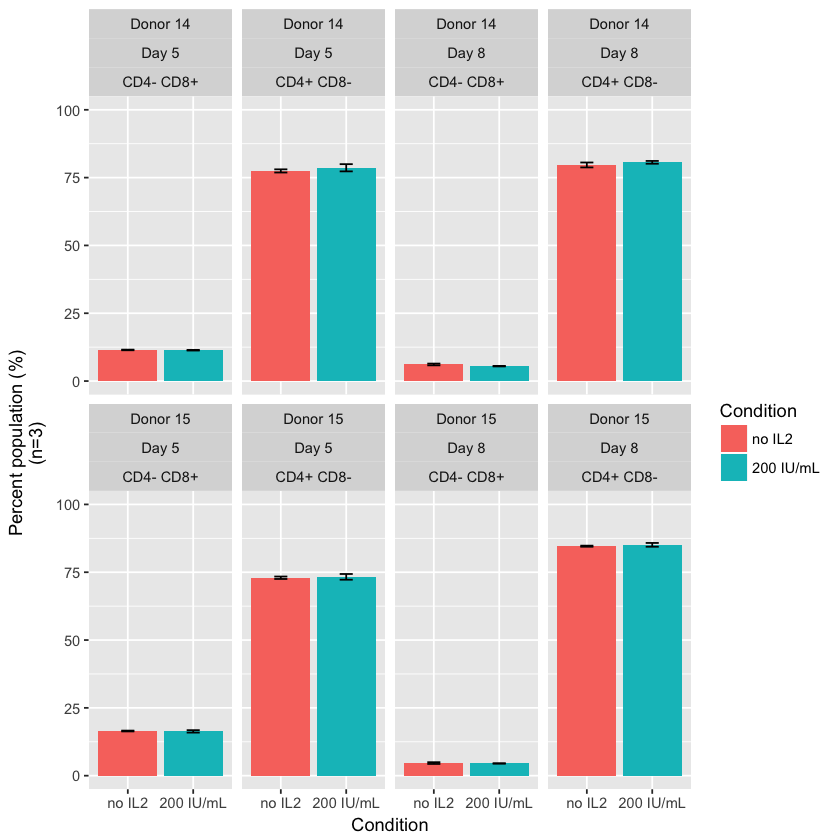

In [57]:
cd48_25 %>%
    ggplot(aes(x=`Condition`, y=`Freq_mean`, fill=`Condition`)) +
    geom_col() +
    geom_errorbar(
        aes(ymax=`Freq_mean`+`Freq_sd`, ymin=`Freq_mean`-`Freq_sd`),
        width=.2
    ) +
    facet_wrap(~`Donor` + `Day` + `Population`, ncol=4) +
    ylab('Percent population (%)\n(n=3)') +
    ylim(0, 100)

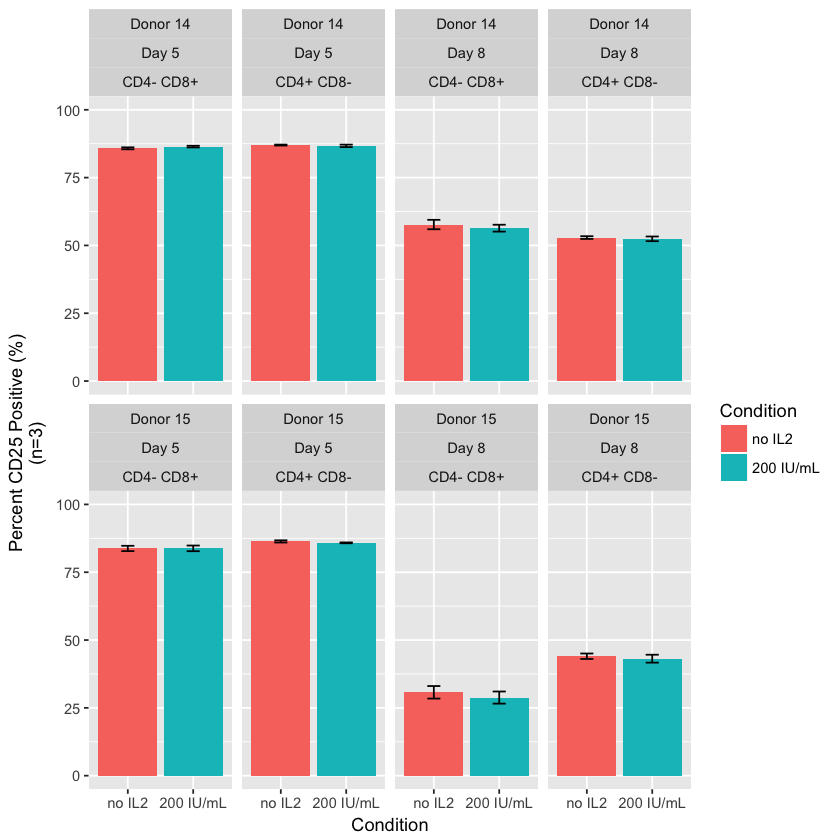

In [59]:
cd48_25 %>%
    ggplot(aes(x=`Condition`, y=`CD25_mean`, fill=`Condition`)) +
    geom_col() +
    geom_errorbar(
        aes(ymax=`CD25_mean`+`CD25_sd`, ymin=`CD25_mean`-`CD25_sd`),
        width=.2
    ) +
    facet_wrap(~`Donor` + `Day` + `Population`, ncol=4) +
    ylab('Percent CD25 Positive (%)\n(n=3)') +
    ylim(0, 100)

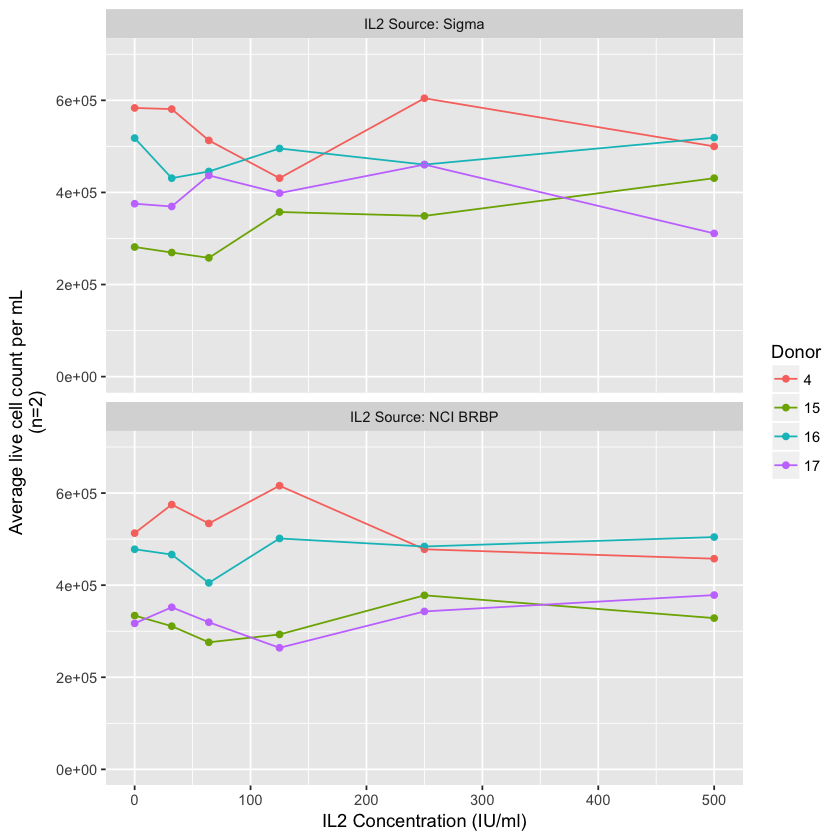

In [61]:
read_tsv(
    'il2-sigma-nih-counts.tsv',
    col_types=cols(
        `donor id`=col_factor(levels=c('4', '15', '16', '17')),
        `Replicate`=col_factor(paste("R", 1:2, sep="")),
        `IL2 Source`=col_factor(levels=c('Sigma', 'NIH')),
        .default=col_number()
    )
) %>%
mutate(
    `Donor`=`donor id`,
    `IL2 Source`=factor(`IL2 Source`, labels=c('IL2 Source: Sigma', 'IL2 Source: NCI BRBP'))
) %>%
group_by(`Donor`, `IL-2 conct`, `IL2 Source`) %>%
summarize(
    `Avg_live_count`=mean(`live count (cells/ml)`)
) %>%
ggplot(aes(x=`IL-2 conct`, y=`Avg_live_count`, color=`Donor`, group=`Donor`)) +
    geom_point() +
    geom_line() +
    facet_wrap(~`IL2 Source`, ncol=1) +
    ylim (0, 7e5) +
    xlab('IL2 Concentration (IU/ml)') +
    ylab('Average live cell count per mL\n(n=2)')


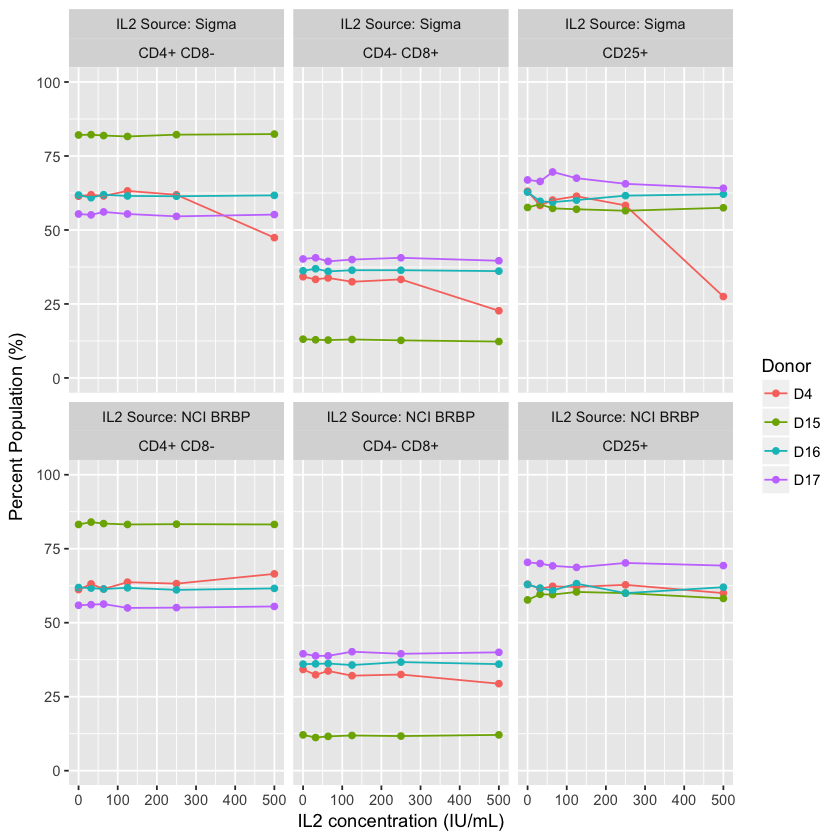

In [62]:
read_tsv(
    'il2-sigma-nih-flow.tsv',
    col_types=cols(
        `Sample:`=col_character(),
        `Donor`=col_factor(levels=c("D4", "D15", "D16", "D17")),
        `IL2 Source`=col_factor(levels=c('Sigma', 'NIH')),
        .default=col_number()
    )
) %>%
mutate(
    `CD4+ CD8-`=`Live/CD4+ CD8- | Freq. of Parent`,
    `CD4- CD8+`=`Live/CD4- CD8+ | Freq. of Parent`,
    `CD25+`=`Live/CD25+ | Freq. of Parent`,
    `IL2 Source`=factor(`IL2 Source`, labels=c('IL2 Source: Sigma', 'IL2 Source: NCI BRBP'))
) %>%
gather(
    key='Population',
    value='Frequency',
    `CD4+ CD8-`:`CD25+`,
    factor_key=TRUE
) %>%
ggplot(aes(x=`IL2 concentration (IU/mL)`, y=`Frequency`, color=`Donor`)) +
    geom_point() +
    geom_line() +
    facet_wrap(~`IL2 Source` + `Population`) +
    ylim(0, 100) +
    ylab('Percent Population (%)')

In [63]:
cd48_grp <-
    read_tsv(
        'il2-flow-long.tsv',
        col_types=cols(
            `Donor`=col_factor(levels=c("D14", "D15")),
            `Day`=col_factor(levels=c("5", "8")),
            `Condition`=col_factor(levels=c("-IL2", "+IL2")),
            `Replicate`=col_factor(levels=paste("r", 1:3, sep="")),
            .default=col_double()
        )
    ) %>%
    mutate(`Day`=factor(`Day`, labels=c("Day 5", "Day 8"))) %>%
    group_by(`Donor`, `Day`, `Condition`)

cd48_25 <- 
    rbind(
        cd48_grp %>%
            summarize(
                `Freq_mean`=mean(`Live/CD4+ CD8- | Freq. of Parent`),
                `Freq_sd`=sd(`Live/CD4+ CD8- | Freq. of Parent`),
                `CD25_mean`=mean(`Live/CD4+ CD8-/CD25+ | Freq. of Parent`),
                `CD25_sd`=sd(`Live/CD4+ CD8-/CD25+ | Freq. of Parent`),
            ) %>%
            mutate(`Population`="CD4+ CD8-"),
        cd48_grp %>%
            summarize(
                `Freq_mean`=mean(`Live/CD4- CD8+ | Freq. of Parent`),
                `Freq_sd`=sd(`Live/CD4- CD8+ | Freq. of Parent`),
                `CD25_mean`=mean(`Live/CD4- CD8+/CD25+ | Freq. of Parent`),
                `CD25_sd`=sd(`Live/CD4- CD8+/CD25+ | Freq. of Parent`),
            ) %>%
            mutate(`Population`="CD4- CD8+")
    )

cd48_25

Donor,Day,Condition,Freq_mean,Freq_sd,CD25_mean,CD25_sd,Population
D14,Day 5,-IL2,77.466667,0.58594653,87.00000,0.1732051,CD4+ CD8-
D14,Day 5,+IL2,78.633333,1.33166562,86.70000,0.4582576,CD4+ CD8-
D14,Day 8,-IL2,79.666667,0.90737717,52.90000,0.5000000,CD4+ CD8-
D14,Day 8,+IL2,80.633333,0.51316014,52.43333,0.8621678,CD4+ CD8-
D15,Day 5,-IL2,72.966667,0.45092498,86.36667,0.4041452,CD4+ CD8-
D15,Day 5,+IL2,73.300000,1.05356538,85.83333,0.1527525,CD4+ CD8-
D15,Day 8,-IL2,84.600000,0.20000000,44.03333,1.0066446,CD4+ CD8-
D15,Day 8,+IL2,85.100000,0.70000000,43.13333,1.4571662,CD4+ CD8-
D14,Day 5,-IL2,11.466667,0.11547005,85.80000,0.3605551,CD4- CD8+
D14,Day 5,+IL2,11.366667,0.11547005,86.43333,0.3055050,CD4- CD8+
